In [1]:
import os
import random
import glob
import gc  # garbage collector

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, Input, MaxPooling2D, Dropout, 
                                     concatenate, UpSampling2D, BatchNormalization, Conv2DTranspose, Activation, add, DepthwiseConv2D)
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import confusion_matrix
import pickle


import warnings
warnings.filterwarnings('ignore')

2024-12-02 22:28:35.308038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 22:28:35.308152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 22:28:35.436434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setup

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found. Please ensure CUDA and cuDNN are properly installed.")

1 Physical GPUs, 1 Logical GPUs


# Utility functions

In [3]:
FULL_SHAPE = (768, 768)
# NEW_SHAPE = (256, 256)
NEW_SHAPE = (128, 128) 

In [4]:
def rle_decode(mask_rle, shape=(768, 768)) -> np.array:
    """
    decode run-length encoded segmentation mask
    Assumed all images aRe 768x768 (and ThereforE have the saMe shape)
    """
    
    # if no segmentation mask (nan) return matrix of zeros
    if not mask_rle or pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)

    # RLE sequence str split to and map to int
    s = list(map(int, mask_rle.split()))

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    # indices: 2k - starts, 2k+1 lengths
    starts, lengths = s[0::2], s[1::2]
    for start, length in zip(starts, lengths):
        img[start:start + length] = 1

    return img.reshape(shape).T

In [5]:
def dice_coeff(y_true, y_pred, smooth=1.0):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def BCE_dice(y_true, y_pred):
    return K.binary_crossentropy(y_true, y_pred) + (1 - dice_coeff(y_true, y_pred))

# def weighted_BCE_dice(y_true, y_pred, weight=10):
#     """
#     Weighted combination of Binary Crossentropy and Dice Loss.
#     Args:
#         y_true: Ground truth labels.
#         y_pred: Predicted labels.
#         weight: Weight for the Dice Loss term.
#     Returns:
#         Weighted loss value.
#     """
#     # Binary Crossentropy Loss
#     bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

#     # Dice Loss
#     y_true_f = tf.keras.backend.flatten(y_true)
#     y_pred_f = tf.keras.backend.flatten(y_pred)
#     intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
#     dice_loss = 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

#     # Weighted Combination
#     return bce_loss + weight * dice_loss

In [6]:
def focal_loss(alpha, gamma):
#     My model use this
  def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    targets = tf.cast(targets, tf.float32)
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

  def loss(y_true, logits):
    y_pred = tf.math.sigmoid(logits)
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

    return tf.reduce_mean(loss)

  return loss

In [7]:
def combined_loss(alpha, gamma, dice_weight=1.0, bce_weight=1.0, focal_weight=1.0):
    """
    Combined loss function of Dice Loss, Binary Crossentropy, and Focal Loss.
    
    Parameters:
    - alpha: Weighting factor for positive class in Focal Loss.
    - gamma: Focusing parameter for Focal Loss.
    - dice_weight: Weight for Dice Loss.
    - bce_weight: Weight for Binary Crossentropy Loss.
    - focal_weight: Weight for Focal Loss.
    
    Returns:
    - A callable combined loss function.
    """
    def loss(y_true, y_pred):
        # Dice Loss
        dice = dice_loss(y_true, y_pred)
        
        # Binary Crossentropy Loss
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        
        # Focal Loss
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        focal = -y_true * alpha * ((1 - y_pred) ** gamma) * tf.math.log(y_pred) \
                - (1 - y_true) * (1 - alpha) * (y_pred ** gamma) * tf.math.log(1 - y_pred)
        focal = tf.reduce_mean(focal)
        
        # Weighted combination
        return dice_weight * dice + bce_weight * bce + focal_weight * focal
    
    return loss

In [8]:
def create_dataset(image_dir, image_filenames, image_masks):
    """Create dataset from image paths and masks."""
    images, masks = [], []
    for image_filename in image_filenames:
        image_path = os.path.join(image_dir, image_filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, NEW_SHAPE)

        mask_rles = image_masks[image_masks['ImageId'] == image_filename]['EncodedPixels']
        mask = np.zeros(FULL_SHAPE, dtype=np.uint8)
        for rle in mask_rles:
            mask += rle_decode(rle)

        mask = cv2.resize(mask, NEW_SHAPE)
        image = image / 255.0

        images.append(image)
        masks.append(mask)

    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    masks_tensor = tf.convert_to_tensor(masks, dtype=tf.uint8)
    return images_tensor, masks_tensor

# Prepare data for U-Net

In [9]:
train_folder_path = '/kaggle/input/airbus-ship-detection/train_v2'
train_masks_path = '/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv'
test_folder_path = '/kaggle/input/airbus-ship-detection/test_v2'

In [10]:
train_masks_df = pd.read_csv(train_masks_path)

In [11]:
class ShipDatasetModified(keras.utils.Sequence):
    
    def __init__(self, image_dir, image_filenames, image_size=(256, 256), batch_size=128):
        # data loader params
        self.image_size = image_size
        self.batch_size = batch_size
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        # read run-length encoded ships
        self.image_masks_df = pd.read_csv(train_masks_path)
    
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        """
        Generate one batch of data
        :param index: Index of the batch
        :return: Batch of images and masks
        """
        # create batch indices
        batch_indices = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        
        # create arrays for images and masks
        batch_images = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)
        batch_masks = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.uint8)
        
        for i, current_image_name in enumerate(batch_indices):
            try:
                # read image and convert to rgb
                image = cv2.imread(os.path.join(self.image_dir, current_image_name))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # get segmentation mask using image filename
                img_rle_seqs = self.image_masks_df.loc[self.image_masks_df['ImageId'] == current_image_name]['EncodedPixels']
                image_mask = np.zeros(FULL_SHAPE, dtype=np.uint8)  # empty mask
                
                for rle in img_rle_seqs:
                    image_mask += rle_decode(rle)
                
                # resize img and its mask
                image = cv2.resize(image, self.image_size)
                image_mask = cv2.resize(image_mask, self.image_size)
                
                image = image / 255.0  # Normalize to [0, 1]
                
                batch_images[i] = image
                batch_masks[i] = np.expand_dims(image_mask, axis=-1)
                
            except Exception as e:
                print(f"Error processing image {current_image_name}: {e}")
        
        return batch_images, batch_masks

    def on_epoch_end(self):
        """
        Updates indices after each epoch
        """
        # shuffle inplace after last batch in epoch
        random.shuffle(self.image_filenames)

    def _load_image(self, image_path):
        """
        Load and preprocess an image
        :param image_path: Path to the image
        :return: Preprocessed image array
        """
        # Load and preprocess an image
        pass

In [12]:
image_filenames = [os.path.basename(filename) for filename in glob.glob(train_folder_path + '/*')]
# random.Random(42).shuffle(image_filenames)
print(image_filenames[:10])
ratio = .8
split_index = int(ratio * len(image_filenames))
train_filenames, val_filenames = image_filenames[: split_index], image_filenames[split_index:]

train_ship_dataset = ShipDatasetModified(train_folder_path, train_filenames)
val_ship_dataset = ShipDatasetModified(train_folder_path, val_filenames)

len(train_ship_dataset), len(val_ship_dataset)

['d8bc90fd6.jpg', 'ee783cf9f.jpg', '4b0d96146.jpg', '7c8d78c3f.jpg', '290f37d66.jpg', '6a91a5706.jpg', '43fa8864a.jpg', '018c1ff4d.jpg', 'a93de8732.jpg', 'e97cb9839.jpg']


(154044, 38512)

In [13]:
train_ship_dataset[0][0].shape

(128, 256, 256, 3)

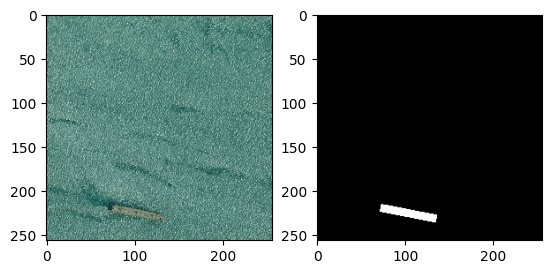

In [14]:
i = 6
some_image, some_mask = train_ship_dataset[0]
some_image = some_image[i]
some_mask = some_mask[i]

fig, ax = plt.subplots(ncols=2)

ax[0].imshow(some_image)
ax[1].imshow(some_mask, cmap='gray')
plt.show()

In [15]:
random.Random(42).shuffle(image_filenames)
train_filenames, val_filenames = image_filenames[: split_index], image_filenames[split_index:]

# random.Random(42).shuffle(train_filenames)
# random.Random(42).shuffle(val_filenames)

# get slice of whole data (i dont want to transform images and compute masks every time i get an dataset item)
train_filenames = train_filenames[:9000]
val_filenames = val_filenames[:1000]

# remove images which does not contain any ships (later)

print(len(train_filenames), len(val_filenames))

gc.collect()

9000 1000


15

In [16]:
X_train, y_train = create_dataset(train_folder_path, train_filenames, train_masks_df)
X_val, y_val = create_dataset(train_folder_path, val_filenames, train_masks_df)

In [17]:
X_train.shape, y_train.shape

(TensorShape([9000, 128, 128, 3]), TensorShape([9000, 128, 128]))

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# train_dataset_iterator = train_dataset.as_numpy_iterator()
# val_dataset_iterator = val_dataset.as_numpy_iterator()

batch_size = 32 # was 64
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)  # no need to shuffle validation data

In [19]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)

In [20]:
X_train = tf.convert_to_tensor(np.load('X_train.npy'))
y_train = tf.convert_to_tensor(np.load('y_train.npy'))
X_val = tf.convert_to_tensor(np.load('X_val.npy'))
y_val = tf.convert_to_tensor(np.load('y_val.npy'))

In [21]:
X_train.shape, y_train.shape

(TensorShape([9000, 128, 128, 3]), TensorShape([9000, 128, 128]))

# U-Net Models for Segmentation Problem

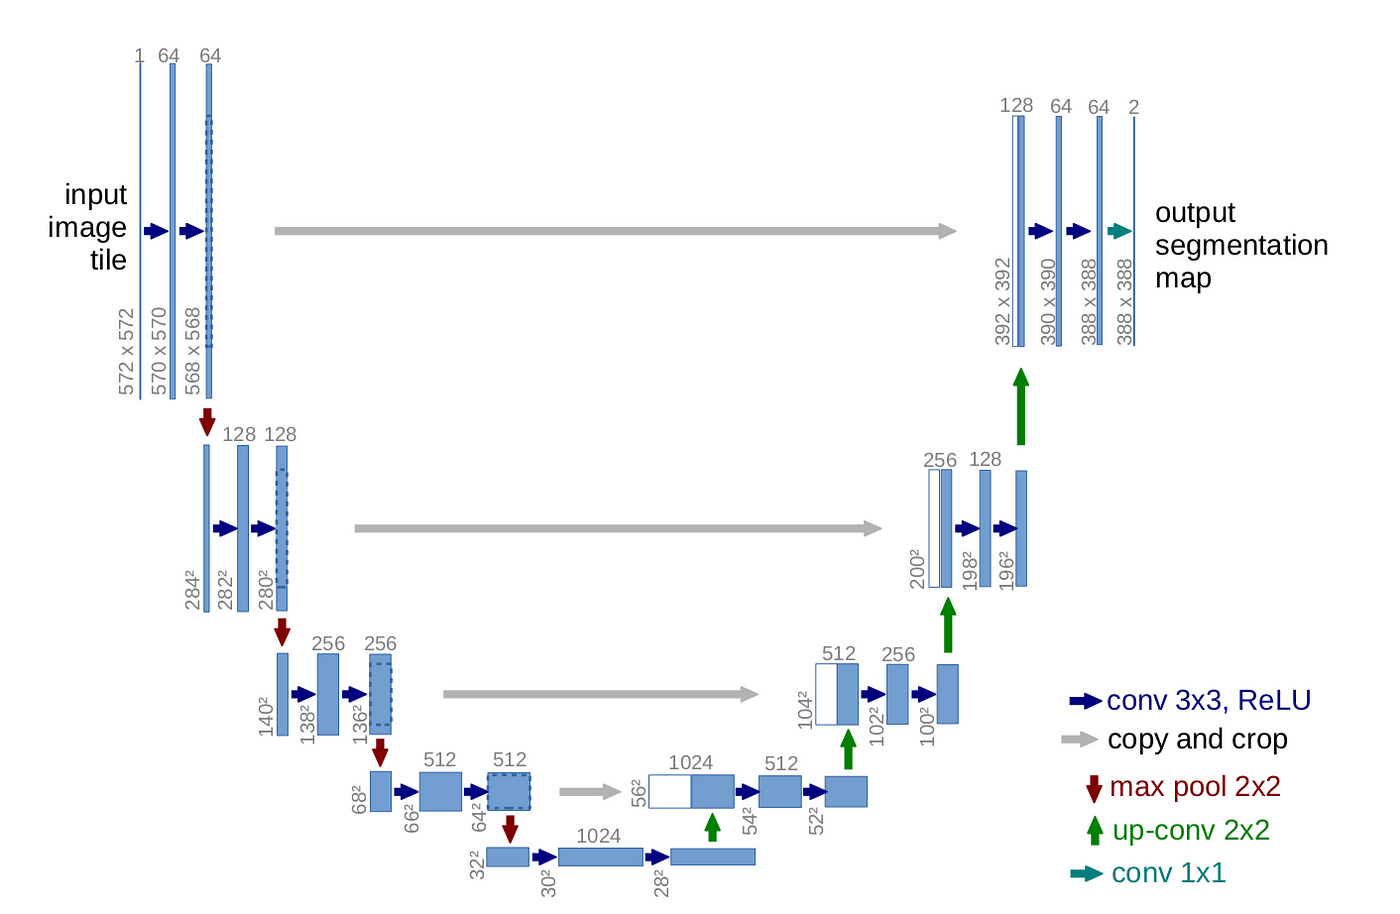


In [22]:
def create_conv2d_block(input_tensor, num_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    
    # 1st layer
    x = Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
        
    x = keras.layers.Activation('relu')(x)
    
    # 2nd layer
    x = Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
    
    x = keras.layers.Activation('relu')(x)
    
    return x

In [23]:
def create_our_conv2d_block(input_tensor, num_filters, kernel_size=5, batchnorm=True):
    """Improved block with depthwise separable convolutions."""
    # Depthwise convolution
    x = DepthwiseConv2D(kernel_size=kernel_size, depth_multiplier=1, padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Pointwise convolution
    x = Conv2D(num_filters, kernel_size=(1, 1), padding='same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [24]:
def get_unet(input_shape, num_filters=16, dropout=0.1, batchnorm=True):
    """
    Function to define the UNET Model
    input_shape: (height, width, 3)
    """
    
    assert input_shape[-1] == 3  # image must have 3 channels
    
    # input 'layer'
    #input_img = Input((*input_shape, 3), name='img')
    input_img = Input(input_shape, name='img')
    
    # downsampling (encoder)
    c1 = create_conv2d_block(input_img, num_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = create_conv2d_block(p1, num_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = create_conv2d_block(p2, num_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = create_conv2d_block(p3, num_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    # bottleneck
    c5 = create_conv2d_block(p4, num_filters * 16, kernel_size=3, batchnorm=batchnorm)
    
    # upsampling (decoder)
    u6 = Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = create_conv2d_block(u6, num_filters * 8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = create_conv2d_block(u7, num_filters * 4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = create_conv2d_block(u8, num_filters * 2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(num_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = create_conv2d_block(u9, num_filters * 1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [25]:
def get_res_unet():
    assert input_shape[-1] == 3  # image must have 3 channels

    input_img = Input(input_shape, name='img')
    
    dropout = 0.1
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conc1 = concatenate([input_img, conv1], axis=3)
    conc1 = BatchNormalization(axis=3, scale=False)(conc1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conc1)
    pool1 = Dropout(dropout)(pool1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conc2 = concatenate([pool1, conv2], axis=3)
    conc2 = BatchNormalization(axis=3, scale=False)(conc2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conc2)
    pool2 = Dropout(dropout)(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conc3 = concatenate([pool2, conv3], axis=3)
    conc3 = BatchNormalization(axis=3, scale=False)(conc3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conc3)
    pool3 = Dropout(dropout)(pool3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conc4 = concatenate([pool3, conv4], axis=3)
    conc4 = BatchNormalization(axis=3, scale=False)(conc4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conc4)
    pool4 = Dropout(dropout)(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conc5 = concatenate([pool4, conv5], axis=3)
    conc5 = BatchNormalization(axis=3, scale=False)(conc5)
    conc5 = Dropout(dropout)(conc5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conc5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conc6 = concatenate([up6, conv6], axis=3)
    conc6 = BatchNormalization(axis=3, scale=False)(conc6)
    conc6 = Dropout(dropout)(conc6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conc6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conc7 = concatenate([up7, conv7], axis=3)
    conc7 = BatchNormalization(axis=3, scale=False)(conc7)
    conc7 = Dropout(dropout)(conc7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conc7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conc8 = concatenate([up8, conv8], axis=3)
    conc8 = BatchNormalization(axis=3, scale=False)(conc8)
    conc8 = Dropout(dropout)(conc8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conc8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conc9 = concatenate([up9, conv9], axis=3)
    conc9 = BatchNormalization(axis=3, scale=False)(conc9)
    conc9 = Dropout(dropout)(conc9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conc9)

    model = Model(inputs=[input_img], outputs=[conv10])

#     model.summary()
    #plot_model(model, to_file='model.png')

    return model

In [26]:
def get_dense_unet():
    assert input_shape[-1] == 3  # image must have 3 channels
    inputs = Input(input_shape, name='img')
    dropout = 0.1
    # Block 1
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conc11 = concatenate([inputs, conv11], axis=3)
    conv12 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc11)
    conc12 = concatenate([inputs, conv12], axis=3)
    conc12 = BatchNormalization(axis=3, scale=False)(conc12)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conc12)
    pool1 = Dropout(dropout)(pool1)

    # Block 2
    conv21 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conc21 = concatenate([pool1, conv21], axis=3)
    conv22 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc21)
    conc22 = concatenate([pool1, conv22], axis=3)
    conc22 = BatchNormalization(axis=3, scale=False)(conc22)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conc22)
    pool2 = Dropout(dropout)(pool2)

    # Block 3
    conv31 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conc31 = concatenate([pool2, conv31], axis=3)
    conv32 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc31)
    conc32 = concatenate([pool2, conv32], axis=3)
    conc32 = BatchNormalization(axis=3, scale=False)(conc32)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conc32)
    pool3 = Dropout(dropout)(pool3)

    # Block 4
    conv41 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conc41 = concatenate([pool3, conv41], axis=3)
    conv42 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc41)
    conc42 = concatenate([pool3, conv42], axis=3)
    conc42 = BatchNormalization(axis=3, scale=False)(conc42)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conc42)
    pool4 = Dropout(dropout)(pool4)

    # Bottleneck
    conv51 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conc51 = concatenate([pool4, conv51], axis=3)
    conv52 = Conv2D(512, (3, 3), activation='relu', padding='same')(conc51)
    conc52 = concatenate([pool4, conv52], axis=3)
    conc52 = BatchNormalization(axis=3, scale=False)(conc52)
    conc52 = Dropout(dropout)(conc52)

    # Decoder Block 1
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conc52), conc42], axis=3)
    conv61 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conc61 = concatenate([up6, conv61], axis=3)
    conv62 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc61)
    conc62 = concatenate([up6, conv62], axis=3)
    conc62 = BatchNormalization(axis=3, scale=False)(conc62)
    conc62 = Dropout(dropout)(conc62)

    # Decoder Block 2
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conc62), conv32], axis=3)
    conv71 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conc71 = concatenate([up7, conv71], axis=3)
    conv72 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc71)
    conc72 = concatenate([up7, conv72], axis=3)
    conc72 = BatchNormalization(axis=3, scale=False)(conc72)
    conc72 = Dropout(dropout)(conc72)

    # Decoder Block 3
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conc72), conv22], axis=3)
    conv81 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conc81 = concatenate([up8, conv81], axis=3)
    conv82 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc81)
    conc82 = concatenate([up8, conv82], axis=3)
    conc82 = BatchNormalization(axis=3, scale=False)(conc82)
    conc82 = Dropout(dropout)(conc82)

    # Decoder Block 4
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conc82), conv12], axis=3)
    conv91 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conc91 = concatenate([up9, conv91], axis=3)
    conv92 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc91)
    conc92 = concatenate([up9, conv92], axis=3)
    conc92 = BatchNormalization(axis=3, scale=False)(conc92)
    conc92 = Dropout(dropout)(conc92)

    # Final Layer
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conc92)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [27]:
# MultiRes Unet
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [28]:
def get_our_unet(input_shape, num_filters=32, dropout=0.1, batchnorm=True):
    assert input_shape[-1] == 3  # image must have 3 channels
    
    # input 'layer'
    #input_img = Input((*input_shape, 3), name='img')
    input_img = Input(input_shape, name='img')
    
    # downsampling (encoder)
    c1 = create_our_conv2d_block(input_img, num_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = create_our_conv2d_block(p1, num_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = create_our_conv2d_block(p2, num_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = create_our_conv2d_block(p3, num_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    # bottleneck
    c5 = create_our_conv2d_block(p4, num_filters * 16, kernel_size=3, batchnorm=batchnorm)
    
    # upsampling (decoder)
    u6 = Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = create_our_conv2d_block(u6, num_filters * 8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = create_our_conv2d_block(u7, num_filters * 4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = create_our_conv2d_block(u8, num_filters * 2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(num_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = create_our_conv2d_block(u9, num_filters * 1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [29]:
def select_model(model_type, input_shape, metrics):
    """
    Select and return the desired model based on model_type.
    
    Parameters:
    - model_type (str): The name of the model to use ('unet', 'res_unet', 'dense_unet', 'multi_res_unet').
    - input_shape (tuple): The input shape of the model.
    - metrics (list): The metrics to use for compiling the model.

    Returns:
    - unet_model: Compiled model.
    """
    if model_type == 'unet':
        unet_model = get_unet(input_shape)
        unet_model._name = "U-Net"
    elif model_type == 'res_unet':
        unet_model = get_res_unet()
        unet_model._name = "Res-U-Net"
    elif model_type == 'dense_unet':
        unet_model = get_dense_unet()
        unet_model._name = "Dense-U-Net"
    elif model_type == 'multi_res_unet':
        unet_model = MultiResUnet(height=NEW_SHAPE[0], width=NEW_SHAPE[1], n_channels=3)
        unet_model._name = "MultiRes-Unet"
    elif model_type == 'our_unet':
        unet_model = get_our_unet(input_shape)
        unet_model._name = "Our-Unet"
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Parameters for the combined loss
    alpha_value = 0.25
    gamma_value = 2.0
    dice_weight = 1.0
    bce_weight = 1.0
    focal_weight = 1.0
    
    # Create the combined loss function
    loss_function = combined_loss(alpha=alpha_value, gamma=gamma_value, 
                                   dice_weight=dice_weight, bce_weight=bce_weight, focal_weight=focal_weight)
    
    # Compile the model
    # focal_loss(alpha=0.25, gamma=2)
    unet_model.compile(optimizer=Adam(0.0005), loss=loss_function, metrics=metrics)
    return unet_model

In [30]:
# Input shape and metrics
input_shape = (*NEW_SHAPE, 3)
metrics = [
    'accuracy',
    dice_coeff,
    dice_loss,
]

In [31]:
# Choose the model type
model_type = "our_unet"  # Change this to 'unet', 'res_unet',  'dense_unet', 'multi_res_unet', or 'our_unet' to use a different model.

# Select and compile the model
unet_model = select_model(model_type, input_shape, metrics)

# Garbage collection
gc.collect()

# Print the selected model
print(f"The model is: {unet_model._name}")

The model is: Our-Unet


In [32]:
callbacks = [
#     EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',   # Monitor validation loss
        factor=0.5,           # Reduce learning rate by a factor of 0.5
        patience=5,           # Wait for 5 epochs with no improvement
        min_lr=1e-6,          # Minimum learning rate
        verbose=1             # Print updates
    ),
    ModelCheckpoint('model-Unet.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir='./logs')
]

In [33]:
history = unet_model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1733179168.640554      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9951 - dice_coeff: 0.0081 - dice_loss: 0.9919 - loss: 1.1249
Epoch 1: val_loss improved from inf to 1.05401, saving model to model-Unet.weights.h5
282/282 ━━━━━━━━━━━━━━━━━━━━ 97s 188ms/step - accuracy: 0.9951 - dice_coeff: 0.0082 - dice_loss: 0.9918 - loss: 1.1247 - val_accuracy: 0.9988 - val_dice_coeff: 0.0024 - val_dice_loss: 0.9976 - val_loss: 1.0540 - learning_rate: 5.0000e-04
Epoch 2/30
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9980 - dice_coeff: 0.1539 - dice_loss: 0.8461 - loss: 0.8608
Epoch 2: val_loss improved from 1.05401 to 0.71454, saving model to model-Unet.weights.h5
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - accuracy: 0.9980 - dice_coeff: 0.1546 - dice_loss: 0.8454 - loss: 0.8601 - val_accuracy: 0.9982 - val_dice_coeff: 0.2891 - val_dice_loss: 0.7109 - val_loss: 0.7145 - learning_rate: 5.0000e-04
Epoch 3/30
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9990 - dice_coeff: 0.4471 - dice_los

# Save training results

In [34]:
with open('unet_history.obj', 'wb') as f:
    pickle.dump(history.history, f)

unet_model.save_weights('winstarsai_airbus_unet.weights.h5')

In [35]:
def plot_training_history(history):
    # Extract the history data
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice_coeff = history.history['dice_coeff']
    val_dice_coeff = history.history['val_dice_coeff']

    epochs = range(1, len(accuracy) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice coefficient
    plt.subplot(1, 3, 3)
    plt.plot(epochs, dice_coeff, 'go', label='Training Dice Coefficient')
    plt.plot(epochs, val_dice_coeff, 'g', label='Validation Dice Coefficient')
    plt.title('Training and validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

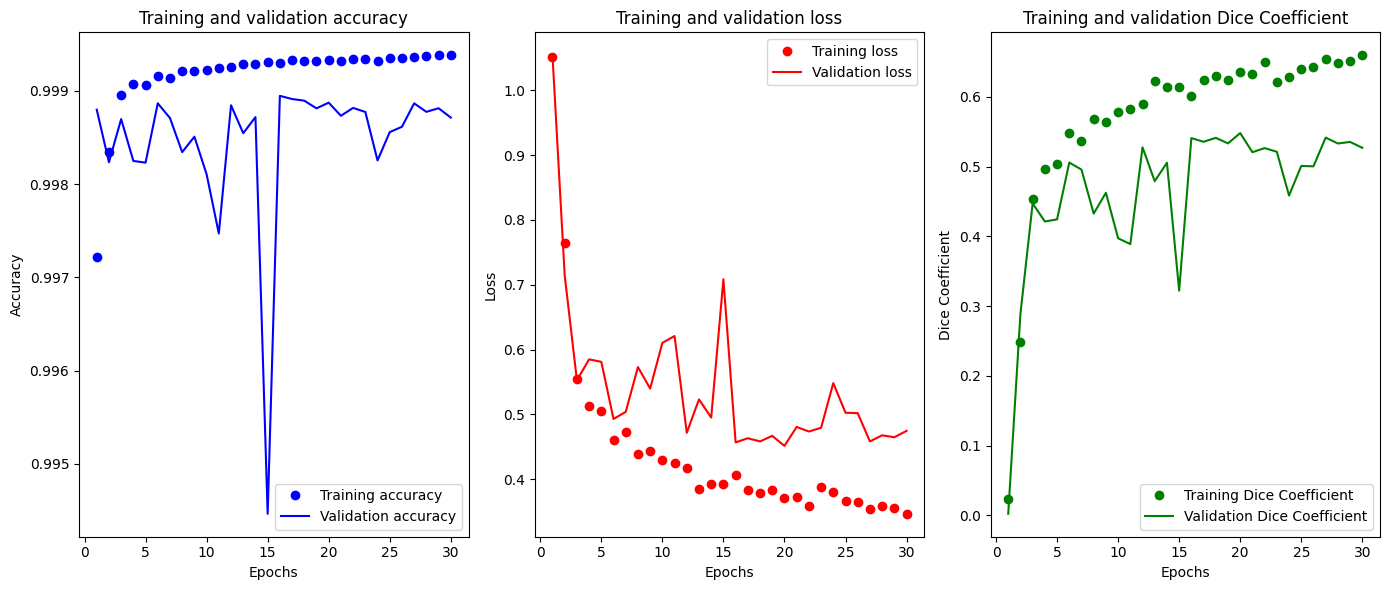

In [36]:
plot_training_history(history)

In [37]:
y_pred = unet_model.predict(X_val)
dice_coeff(y_pred,y_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.5763859>

In [38]:
if not isinstance(y_pred, np.ndarray):
    y_pred = y_pred.numpy()

if not isinstance(y_val, np.ndarray):
    y_val = y_val.numpy()

y_pred = y_pred > 0.5
y_pred_flat = y_pred.flatten() 
y_true_flat = y_val.flatten() 
# Calculate the confusion matrix 
tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat).ravel() 
# Calculate accuracy 
accuracy = (tp + tn) / (tp + tn + fp + fn) 
# Calculate precision 
precision = tp / (tp + fp) 
# Calculate sensitivity (recall) 
sensitivity = tp / (tp + fn) 
# Calculate specificity 
specificity = tn / (tn + fp) 
# Calculate Dice Coefficient
dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
# Print the metrics 
print(f'Dice Coefficient: {dice_coefficient:.4f}')
print(f'Accuracy: {accuracy:.4f}') 
print(f'Precision: {precision:.4f}') 
print(f'Sensitivity (Recall): {sensitivity:.4f}') 
print(f'Specificity: {specificity:.4f}')


Dice Coefficient: 0.5803
Accuracy: 0.9987
Precision: 0.4773
Sensitivity (Recall): 0.7401
Specificity: 0.9990


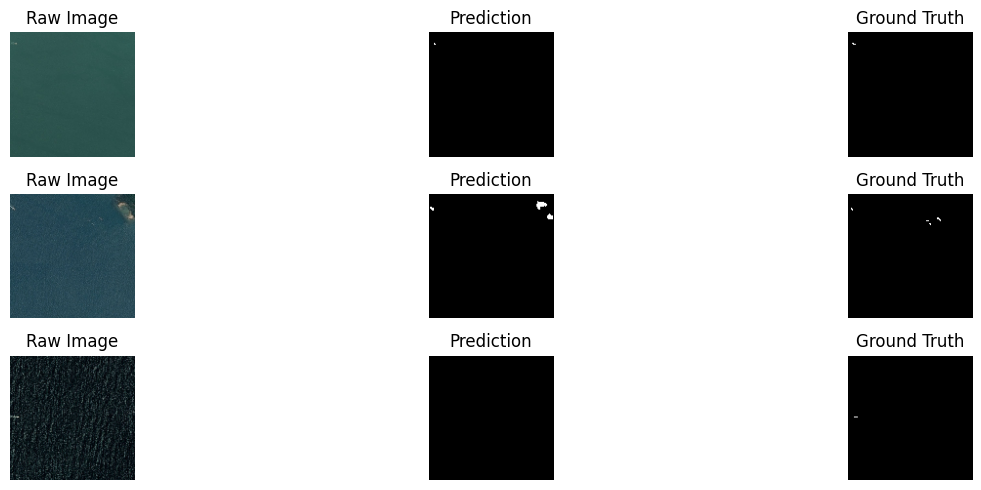

In [39]:
if not isinstance(X_val, np.ndarray):
    X_val = X_val.numpy()

def visualize_ship_examples(raw_images, y_pred, y_true, num_examples=3):
    """
    Visualize examples where the ground truth contains ships.

    Parameters:
    - raw_images: Original input images.
    - y_pred: Predicted segmentation masks.
    - y_true: Ground truth segmentation masks.
    - num_examples: Number of examples to display.
    """
    # Find indices where the ground truth contains ships
    ship_indices = [i for i in range(len(y_true)) if y_true[i].max() > 0]

    if len(ship_indices) < num_examples:
        print(f"Only {len(ship_indices)} examples with ships are available.")
        num_examples = len(ship_indices)

    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        idx = ship_indices[i]  # Select index with ship

        # Raw image
        plt.subplot(num_examples, 3, i * 3 + 1)
        plt.imshow(raw_images[idx].squeeze(), cmap='gray')
        plt.title("Raw Image")
        plt.axis('off')

        # Model prediction
        plt.subplot(num_examples, 3, i * 3 + 2)
        plt.imshow(y_pred[idx].squeeze(), cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

        # Ground truth
        plt.subplot(num_examples, 3, i * 3 + 3)
        plt.imshow(y_true[idx].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_ship_examples(X_val, y_pred, y_val)
